In [1]:
%config Completer.use_jedi = False

In [1]:
import json
import os
import sys

import mne
import numpy as np
import pandas as pd

import pac



suffix = '_1_50'
gamma = [10, 80]
beta  = [ 1, 16]


In [2]:
def create_tasks_df(ds_path=None):
    if ds_path is None:
        with open('config.json') as f:
            config = json.load(f)
        base_path = config['BASE_PATH']
        ds_path = os.path.join(base_path, 'ds003490-download')

    df = pd.read_csv(os.path.join(ds_path, 'participants.tsv'), sep="\t")
    tasks = []

    for _, participant in df.iterrows():
        if participant.Group == 'PD':
            sessions = [(1, 1 * (participant.sess1_Med == 'ON')),
                        (2, 1 * (participant.sess2_Med == 'ON'))]
        else:
            sessions = [(1, 2)]

        for sess, pd_drug_type in sessions:
            participant_tasks = {}
            participant_tasks['participant_id'] = participant['participant_id']
            participant_tasks['pd_drug_type'] = pd_drug_type
            participant_tasks['isMale'] = participant['sex'] == 'Male'
            participant_tasks['age'] = participant['age']
            participant_tasks['dir'] = os.path.join(ds_path, participant['participant_id'], f'ses-{sess:02}', 'eeg', )
            participant_tasks[
                'file'] = f'{participant["participant_id"]}_ses-{sess:02}_eeg_{participant["participant_id"]}_ses-{sess:02}_task-Rest_eeg.mat'
            participant_tasks['file_formatter'] = f'{participant["participant_id"]}_ses-{sess:02}_task-Rest_{{}}'
            participant_tasks['path'] = os.path.join(
                participant_tasks['dir'], participant_tasks['file'])

            tasks.append(participant_tasks)

    tasks_df = pd.DataFrame(tasks)

    return tasks_df


def _test_tasks_df(tasks_df, i=0):
    task = tasks_df.iloc[i]

    assert os.path.exists(task.path)

    ds = sio.loadmat(task.path)

    ds['data'] = ds['EEG']

    nbchan = ds['data'][0, 0]['nbchan'][0, 0]  # .dtype
    Fs = ds['data'][0, 0]['srate'][0, 0]
    times = ds['data'][0, 0]['times']
    data = ds['data'][0, 0]['data']

    dtypes = [k for k in ds['data'][0, 0]['event'].dtype.names]
    events = pd.DataFrame([{n: event[n].item() if event[n].size > 0 else None for n in dtypes}
                           for event in ds['data'][0, 0]['event'][0]])

    electrodes = pd.read_csv(os.path.join(
        task['dir'], task['file_formatter'].format('electrodes.tsv')), sep='\t')

    reject = ds['data'][0, 0]['reject']

    print(events)


# Create Task list in `tasks_df`

In [3]:
def check_completed(task, event=None) -> bool:
    json_path = os.path.join(task['dir'], task['file_formatter'].format(f'completed{suffix}.json'))
    completed = {}
    if os.path.exists(json_path):
        with open(json_path) as f:
            completed = json.load(f)
    
    if event is None:
        return completed.get('total', False)
    else:
        return completed.get(event, False)


def update_completed(task, event=None) -> bool:
    json_path = os.path.join(task['dir'], task['file_formatter'].format(f'completed{suffix}.json'))
    completed = {}
    if os.path.exists(json_path):
        with open(json_path) as f:
            completed = json.load(f)

    if event is None:
        completed['total'] = True
    else:
        completed[event] = True
        
    with open(json_path, 'w') as f:
        json.dump(completed, f)


In [4]:
def analyse_erps(erps: dict, task=None):
    mvls = {}
    mvl_2ds = {}
    mvl_2d_times = {}
    
    steps = list(range(-200, 1000 + 1, 200))
    
    groups = ['PD Med Off', 'PD Med On', 'CTL']

    for event_type, erp in erps.items():
        mvl_2d = np.zeros(
            (erp.info['nchan'], erp.info['nchan'], gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
        mvl_2d_time = np.zeros((erp.info['nchan'], gamma[1] - gamma[0] + 1, 
                                beta[1] - beta[0] + 1, len(steps) - 1 ))

        mvl = np.zeros((erp.info['nchan'], erp.info['nchan'],))
        tfds = {}

        erp_df = erp.to_data_frame()
        erp_df = erp_df.set_index('time')

        if task is not None:
            print(f'{task.participant_id} {groups[task.pd_drug_type]:10} {event_type} tfd started')

        for ch in erp_df:
            tfd = pac.rid_rihaczek(erp_df[ch], int(erp.info['sfreq']))
            tfds[ch] = tfd

        for chx, chxname in enumerate(erp_df):
            chy = chx
            chyname = chxname
            
            for i, ts in enumerate(zip(steps[:-1], steps[1:])):
                tstart, tend = ts
                ind_start = np.where(erp_df.index == tstart)[0][0]
                ind_end   = np.where(erp_df.index == tend)[0][0]
                mvl_2d_time[chx, :, :, i] = pac.tfMVL_tfd2_2d_time(
                    tfds[chxname], tfds[chxname], gamma, beta, ind_start, ind_end)

            
            for chy, chyname in enumerate(erp_df):
                # todo:
                # if(check_completed(task, f'{event_type}_{chxname}_{chyname}')):
                #     continue

                mvl_2d[chx, chy] = pac.tfMVL_tfd2_2d(
                    tfds[chxname], tfds[chyname], gamma, beta)
                mvl[chx, chy] = mvl_2d[chx, chy].sum()
            # mvl[chx, chy] = pac.tfMVL_tfd2(
            #     tfds[chxname], tfds[chyname], gamma, beta)

        mvls[event_type] = mvl
        mvl_2ds[event_type] = mvl_2d
        mvl_2d_times[event_type] = mvl_2d_time

    return mvls, mvl_2ds, mvl_2d_times

In [5]:
def analyse_sub(task):
    if (check_completed(task)):
        return

    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg.set')),
                                 preload=True, verbose=0)
    # raw.drop_channels(['X', 'Y', 'Z'])
    raw.drop_channels(['VEOG'])
    raw.set_eeg_reference()
    
    for ch in raw._data:
        ch -= ch.mean()
        ch /= ch.std()

    # create_elc_file(task)
    # montage = mne.channels.read_custom_montage(os.path.join(
    #     task.dir, task.file_formatter.format('electrodes.elc')))
    montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
    raw.set_montage(montage)

    # mne.viz.plot_topomap(raw._data[:, 194000], raw.info, axes=ax,
    #                      show=False)

    # eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=True)
    # freqs = (60, 120, 180, 240)
    # raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks, verbose=0)
    # raw_filtered = raw_notch.copy().filter(l_freq=1, h_freq=150, verbose=0)
    
    events, event_dict = mne.events_from_annotations(raw, verbose=0)

    selected_events = ['S200', 'S201', 'S202']
    event_types = {'S200': 'Target', 'S201': 'Standard', 'S202': 'Novelty'}
    kwargs = {'S200': {'baseline': (0.250, 0.450), 'tmin': 0.250, 'tmax':1.450},
              'S201': {'baseline': (0.250, 0.450), 'tmin': 0.250, 'tmax':1.450},
              'S202': {'baseline': (-.200,     0), 'tmin': -.200, 'tmax':1.000},}

    erps = {}
    epochs_data = {}
    for ev in selected_events:
        epochs = mne.Epochs(raw, events[events[:, 2] == event_dict[ev]],
                            event_id={ev: event_dict[ev]}, preload=True, verbose=0, **(kwargs[ev]))
        erps[ev] = epochs[ev].average()
        epochs_data[ev] = epochs[ev]._data
        
        
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'epochs')),
                        **epochs_data)
    
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'erps')),
                        **erps)
    
#     return

    mvls, mvl_2ds, mvl_2d_times = analyse_erps(erps, task)
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'mvls{suffix}')),
                        **mvls)
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2ds{suffix}')),
                        **mvl_2ds)
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2d_times{suffix}')),
                        **mvl_2d_times)
    update_completed(task)
    print(f'{task.participant_id} completed')

# Main

In [6]:
if __name__ == '__main__':
    tasks_df = create_tasks_df()

#     analyse_sub(tasks_df.iloc[0])

    # from multiprocessing import Pool
    # with Pool(4) as p:
    #    p.map(analyse_sub, tasks_df.iloc)

#     for task in tasks_df.iloc:
#         analyse_sub(task)
    print('finished')

finished


# Single Subject

In [7]:
task = tasks_df.iloc[0]
if 1:
    if (check_completed(task)):
        pass
    
    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg.set')),
                                 preload=True, verbose=0)
    # raw.drop_channels(['X', 'Y', 'Z'])
#     raw.drop_channels(['VEOG'])
#     raw.set_eeg_reference()
    
#     for ch in raw._data:
#         ch -= ch.mean()
#         ch /= ch.std()

    # create_elc_file(task)
    # montage = mne.channels.read_custom_montage(os.path.join(
    #     task.dir, task.file_formatter.format('electrodes.elc')))
    montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
    raw.set_montage(montage)

    # mne.viz.plot_topomap(raw._data[:, 194000], raw.info, axes=ax,
    #                      show=False)

    # eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=True)
    # freqs = (60, 120, 180, 240)
    # raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks, verbose=0)
    # raw_filtered = raw_notch.copy().filter(l_freq=1, h_freq=150, verbose=0)
    
    events, event_dict = mne.events_from_annotations(raw, verbose=0)

    selected_events = ['S200', 'S201', 'S202']
    event_types = {'S200': 'Target', 'S201': 'Standard', 'S202': 'Novelty'}
    kwargs = {'S200': {'baseline': (0.250, 0.450), 'tmin': 0.250, 'tmax':1.450},
              'S201': {'baseline': (0.250, 0.450), 'tmin': 0.250, 'tmax':1.450},
              'S202': {'baseline': (-.200,     0), 'tmin': -.200, 'tmax':1.000},}

    erps = {}
    epochs_data = {}
    for ev in selected_events:
        epochs = mne.Epochs(raw, events[events[:, 2] == event_dict[ev]],
                            event_id={ev: event_dict[ev]}, preload=True, verbose=0, **(kwargs[ev]))
        erps[ev] = epochs[ev].average()
        epochs_data[ev] = epochs[ev]._data
        

<ipython-input-7-d92181a1c850>:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  preload=True, verbose=0)


ValueError: Channel(s) VEOG not found, nothing dropped.

In [33]:
if 1:
    mvls = {}
    mvl_2ds = {}
    mvl_2d_times = {}
    
    steps = list(range(-200, 1000 + 1, 200))
    
    groups = ['PD Med Off', 'PD Med On', 'CTL']

    for event_type, erp in erps.items():
        mvl_2d = np.zeros(
            (erp.info['nchan'], erp.info['nchan'], gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
        mvl_2d_time = np.zeros((erp.info['nchan'], gamma[1] - gamma[0] + 1, 
                                beta[1] - beta[0] + 1, len(steps) - 1 ))

        mvl = np.zeros((erp.info['nchan'], erp.info['nchan'],))
        tfds = {}

        erp_df = erp.to_data_frame()
        erp_df.time = list(range(-200, 1000 + 1, 2))
        erp_df = erp_df.set_index('time')

        if task is not None:
            print(f'{task.participant_id} {groups[task.pd_drug_type]:10} {event_type} tfd started')

        for ch in erp_df:
            tfd = pac.rid_rihaczek(erp_df[ch], int(erp.info['sfreq']))
            tfds[ch] = tfd

        for chx, chxname in enumerate(erp_df):
            chy = chx
            chyname = chxname
            
            for i, ts in enumerate(zip(steps[:-1], steps[1:])):
                tstart, tend = ts
                ind_start = np.where(erp_df.index == tstart)[0][0]
                ind_end   = np.where(erp_df.index == tend)[0][0]
                mvl_2d_time[chx, :, :, i] = pac.tfMVL_tfd2_2d_time(
                    tfds[chxname], tfds[chxname], gamma, beta, ind_start, ind_end)

            
            for chy, chyname in enumerate(erp_df):
                # todo:
                # if(check_completed(task, f'{event_type}_{chxname}_{chyname}')):
                #     continue

                mvl_2d[chx, chy] = pac.tfMVL_tfd2_2d(
                    tfds[chxname], tfds[chyname], gamma, beta)
                mvl[chx, chy] = mvl_2d[chx, chy].sum()
            # mvl[chx, chy] = pac.tfMVL_tfd2(
            #     tfds[chxname], tfds[chyname], gamma, beta)

        mvls[event_type] = mvl
        mvl_2ds[event_type] = mvl_2d
        mvl_2d_times[event_type] = mvl_2d_time

sub-001 PD Med On  S200 tfd started
sub-001 PD Med On  S201 tfd started
sub-001 PD Med On  S202 tfd started


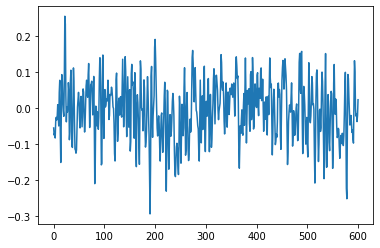

In [25]:
erp = epochs_data['S201'].mean(axis=0)[10, :]
plt.plot(erp)
plt.show()

In [34]:
np.savez_compressed('/home/kiani/DS/ds003490-download/extracted_data/mvls30_6_sub1.npz',
                    **mvl_2ds)


In [35]:
mvl_2ds['S200'].shape

(63, 63, 61, 13)